# Classification of Images of CIFAR-10

CIFAR-10 dataset contains in total 60,000 colour images, divided into ten classes. The task of this project is to identify an image belonging to one of these ten categories.

## Data Preparation
At the first stage, we load the relevant libraries and dataset CIFAR-10 and pre-process images together with data augmentation. After experiments, the optimal batch size is 256. It is an important hyperparameter for model optimisation.   

In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torchvision
from torchvision import datasets, transforms, models
from torchviz import make_dot
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
import seaborn as sns

#turn off graphics tuning if necessary
from jupyterthemes import jtplot
jtplot.style(theme="grade3", context="notebook", ticks=True, grid=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
print("PyTorch version: ", torch.__version__ )
print("CUDA available: ", torch.cuda.is_available())
# print("CUDA version: ", torch.version.cuda)
#We resize images to 32x32 pixels
#We apply stransformations on training set and normalise
transform_train = transforms.Compose([transforms.Resize((32,32)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomRotation(10),
                                      transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
                                     # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                                      transforms.ToTensor(),# values to normalise from Github
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                               ])

transform_test = transforms.Compose([transforms.Resize((32,32)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                               ])
#we extract dataset from pytorch repository
training_dataset = datasets.CIFAR10(root='../Advanced Machine/Data_Sets/Cifar10',
                              train=True, download=True,
                              transform=transform_train)
validation_dataset = datasets.CIFAR10(root='.../Advanced Machine/Data_Sets/Cifar10',
                                 train=False, download=True,
                                 transform=transform_test)

train_loader = torch.utils.data.DataLoader(training_dataset, batch_size=256, shuffle=True)
val_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = 256, shuffle=False)

PyTorch version:  1.3.1
CUDA available:  True
Files already downloaded and verified
Files already downloaded and verified


## Parameter Optimisation through Residual Neural Network

In this project, we have the training set made up of 50,000 images with ten classes to classify. The test set contains 10,000 images. To achieve 90 per cent test accuracy, we used a residual convolutional neural network [1] , which is made of residual blocks. The idea is that after a series of convolution-ReLU-convolution operations, the signal is passed to the output. Some blocks can be by-passed and final signal be still strong enough. In this way, we mitigate the problem of vanishing gradients and can build more deep networks in which we do not rely on mapping from input to output, but on residual mapping instead. In other words, we "skip connections".\
Images in CIFAR10 are 32x32 so it is convinient to apply automatic convolution with kernel size of 3 and padding of 1 in order not to lose any pixels. To capture growing complexity of features we apply increased number of filters from 32 to 256. We hareness typical function 'builder' to expand structure of blocks along neural network (NN). The detailed structure of NN is depicted below (scroll down).  

In [2]:
###################################### functions ##################################################
def conva(ins, outs, stride=1):
    '''General convolution 3x3'''
    x = nn.Conv2d(ins, outs, kernel_size=3,stride=stride, padding=1, bias=False)
    return x

def accuracy(outputs, labels):
    '''Computes accuracy'''
    pred = 0.0
    _, val_preds = torch.max(outputs, 1)
    pred += torch.sum(val_preds == labels.data)
    return pred

#### Neural Network Flow

In [3]:
# Residual block class to expand the structure of blocks
class ResBlock(nn.Module):
    def __init__(self, in_chann, out_chann, stride=1, shortcut=None):
        '''pass through convolutions'''
        super(ResBlock, self).__init__()
        self.conv1 = conva(in_chann, out_chann, stride)
        self.bn1 = nn.BatchNorm2d(out_chann)# For batch normalisation, i.e. rescaling the inputs of the activations 
        #self.relu = nn.LeakyReLU(0.95, inplace=True)
        self.relu = nn.ReLU(inplace=True) # After batchnorm there is no need to store outputs for backward pass.
        self.conv2 = conva(out_chann, out_chann)
        self.bn2 = nn.BatchNorm2d(out_chann)
        self.relu = nn.ReLU(inplace=True)
        self.conv3 = conva(out_chann, out_chann)
        self.bn3 = nn.BatchNorm2d(out_chann)
        #no ReLU here
#         self.conv4 = conva(out_chann, out_chann)
#         self.bn4 = nn.BatchNorm2d(out_chann)
        self.shortcut = shortcut# to skip connections
        
    def forward(self, x):
        '''forward pass through blocks and outside blocks'''
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv3(out)
        out = self.bn3(out)
        #no ReLU here
#         out = self.conv4(out)
#         out = self.bn4(out)
        if self.shortcut: #if shortcut then signal is directed forward to omit block(s)
            residual = self.shortcut(x)
        out += residual
        out = self.relu(out)
        return out

#### Neural Network Skeleton

In [4]:
class FFNN(nn.Module): 
    def __init__(self):
        '''The backbone of the model'''
        super(FFNN, self).__init__()
        self.in_chann = 32
        self.conv = conva(3, 32)
        self.bn = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)
        #There are seven residual blocks
        self.layer1 = self.builder(ResBlock, 32, 2)# two blocks: 32 -> to 32 and 32 -> 32; kernel=32
        self.layer2 = self.builder(ResBlock, 64, 2, 2)# two blocks: 32 -> to 64 and 64 -> 64; k=16 
        self.layer3 = self.builder(ResBlock, 128, 2, 2)# two blocks: 64 -> to 128 and 128 -> 128; k=8
        self.layer4 = self.builder(ResBlock, 256, 1, 2)# one blocks: 128 -> to 256; k=4
        self.avg_pool = nn.AvgPool2d(4) #to summarise information in the kernel to a single average
        ##start feedforward NN
        self.fc1 = nn.Linear(256, 1024)
        #self.fc1_drop = nn.Dropout2d(p=0.2)
        self.fc2 = nn.Linear(1024, 512)
        #self.fc2_drop = nn.Dropout2d(p=0.2)
        #self.fc3 = nn.Linear(512, 256)
        #self.fc2_drop = nn.Dropout2d(p=0.4)
        self.fc = nn.Linear(512, 10) # ->> OUTPUTS
        
    def builder(self, block, out_chann, n_blocks, stride=1):
        '''Typical expander of residual blocks.'''
        shortcut = None
        # To adjust size of the signal via convolution, that is signals must suit
        # between diffrent blocks.
        if (stride != 1) or (self.in_chann != out_chann):
            shortcut = nn.Sequential(
                conva(self.in_chann, out_chann, stride=stride),
                nn.BatchNorm2d(out_chann))
        layers = []
        layers.append(block(self.in_chann, out_chann, stride, shortcut))
        self.in_chann = out_chann
        for _ in range(1, n_blocks):
            layers.append(block(out_chann, out_chann))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        '''Forward pass through whole NN'''
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        #out = self.fc1_drop(out)
        out = F.relu(self.fc2(out))
        #out = self.fc2_drop(out)
        #out = F.relu(self.fc3(out))
        x = self.fc(out)
        return x
    
    def fit(self, n_epochs, learn_rate, model, train_load, test_load):
        '''Trainer'''
        torch.backends.cudnn.benchmark=True
        self.to(device) #to GPU
        criterion = nn.CrossEntropyLoss()# loss function
        # Adam due to adaptive rate and momentum(when gradient changes sign too quickly) 
        optimizer = torch.optim.Adam(model.parameters(), lr = learn_rate) # this rate seems OK
        epochs = n_epochs
        self.run_train_loss = []#storage
        self.run_train_acc = []
        self.run_test_loss = []
        self.run_test_acc = []
        self.batches_train = []
        self.batches_test = []
        torch.backends.cudnn.benchmark=True # They say it could be faster
        for k in range(epochs):
            train_loss = 0.0 #start from something
            train_acc = 0.0
            test_loss = 0.0
            test_acc= 0.0
            
            model.train() #train mode
            torch.backends.cudnn.benchmark=True
            for inputs, labels in train_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)# model processes
                loss = criterion(outputs, labels)# loss is computed
                self.batches_train.append(loss.item())# needed for plots
                optimizer.zero_grad() # reset values of derivativesfrom graphs
                loss.backward() # BACKPROPAGATION
                optimizer.step() # parameter update based on current gradient stored in .grad attribute of a parameter
                train_loss += loss.item() # accumaulate loss (should go down )
                train_acc += accuracy(outputs, labels) # accuracy
            else:
                model.eval()# eval mode to turn off dropouts or batchnormalisation
                torch.backends.cudnn.benchmark=True
                with torch.no_grad():# wrapper temporarily puts all 'requires_grad flag' to flase. Faster
                    #below is obvious
                    for tes_inputs, tes_labels in val_loader:
                        tes_inputs = tes_inputs.to(device)
                        tes_labels = tes_labels.to(device)
                        tes_outputs = model(tes_inputs)
                        tes_loss = criterion(tes_outputs, tes_labels)
                        self.batches_test.append(tes_loss.item())
                        test_loss += tes_loss.item()
                        test_acc += accuracy(tes_outputs, tes_labels.data )

                epoch_loss = train_loss/len(train_loader)
                epoch_acc = train_acc.float()/ len(train_loader.dataset) #divide by the longth of entire dataset
                self.run_train_loss.append(epoch_loss)
                self.run_train_acc.append(epoch_acc)

                tes_epoch_loss = test_loss/len(val_loader)
                tes_epoch_acc = test_acc.float()/ len(val_loader.dataset)
                self.run_test_loss.append(tes_epoch_loss)
                self.run_test_acc.append(tes_epoch_acc)
                
                if (k + 1) % 1 == 0:    
                        print('Epoch [{}/{}], Loss: {:.4f} / {:.4f}, Accuracy: {:.4f}  / {:.4f} '\
                              .format(k + 1, epochs, self.run_train_loss[k], self.run_test_loss[k], self.run_train_acc[k], self.run_test_acc[k]))
                                                 
    def plotti(self):
        fig, ax = plt.subplots(2, 2, figsize=(14, 10))
        ax[0,0].plot(self.run_train_loss,c='b',linewidth=1.8, label='Train loss')
        ax[0,0].plot(self.run_test_loss,c='r',linewidth=1.8, label='Test loss')
        ax[1,0].plot(self.batches_train, c='grey', alpha=0.5, label='Train minibatch cost')
        ax[1,0].plot(np.convolve(self.batches_train, np.ones(10,)/10, mode='valid'),linewidth=1 , label='Running average')
        ax[1,1].plot(self.batches_test, c='grey', alpha=0.5, label='Test minibatch cost')
        ax[1,1].plot(np.convolve(self.batches_test, np.ones(10,)/10, mode='valid'), c='r',linewidth=1 , label='Running average')
        ax[0,1].plot(self.run_test_acc, c='r',linewidth=1.8, label='Test accuracy')
        ax[0,1].plot(self.run_train_acc, c='b',linewidth=1.8, label='Train accuracy')
        ax[0,0].set(xlabel="Epochs",ylabel="Loss")
        ax[0,1].set(xlabel="Epochs",ylabel="Accuracy")
        ax[0,1].set(ylabel="Accuracy")
        ax[1,0].set(xlabel="Number of iterations", ylabel="Train CrossEntropy")
        ax[1,1].set(xlabel="Number of iterations", ylabel="Test CrossEntropy")
        ax[0,0].legend(), ax[0,1].legend(), ax[1,0].legend(), ax[1,1].legend()
        plt.show()

#### Neural Network Visualisation
The graph below depicts the detailed structure of customed-made NN. There are seven residuals blocks altogether. A signal goes through or bypass them. For each pass, we have 256 samples (after passing on them the weight and biases are updated). The first convolution operates on 32 filters with a kernel of 3 and stride and padding of one. In this way, we do not lose any pixels due to the shift of kernel over the edges. There are four layers. The first three are made up of two residual blocks, the last of one only. The signal (number of pixels) is halved between each layer so as we end up with size 4x4. After all, we summarise information in the kernel to a single average employing average pooling.  
The reader can easily read the structure of the neural network from the diagram, that is a number of blocks, filters and to compare it to the lines of code, more precisely to the '''The backbone of the model''' in the script above. Also, operations on graphs, batch normalisation and particular layers plus bypasses are pretty visible.
After convolutions, we use batch normalisation to rescale the inputs of the activations. It is good reguliser. As activation functions, we use typical ReLU as they "keep" gradients in a nice way. ReLUs are simple enough, but many of them together in neural networks allows us to build almost arbitrary shape curves on the feature plane.\
Regarding hyperparameters, we use 256 batch size. It seems to be a good trade-off between speed of optimisation and desired accuracy. As an optimiser, we employed Adam since it uses past gradients to compute present gradients and momentum. The latter is using moving average instead of the gradient itself. The learning rate was set to 0.0005. It is low what is typical for Adam.  We perform optimisation on cross-entropy as a loss function to measure the difference between distributions of classified objects. Cross-entropy plays well with activation functions as the derivative depends only on neuron's output, target, and neuron's input. In other words, cross-entropy deals well with the potential problem of saturated neurons. 

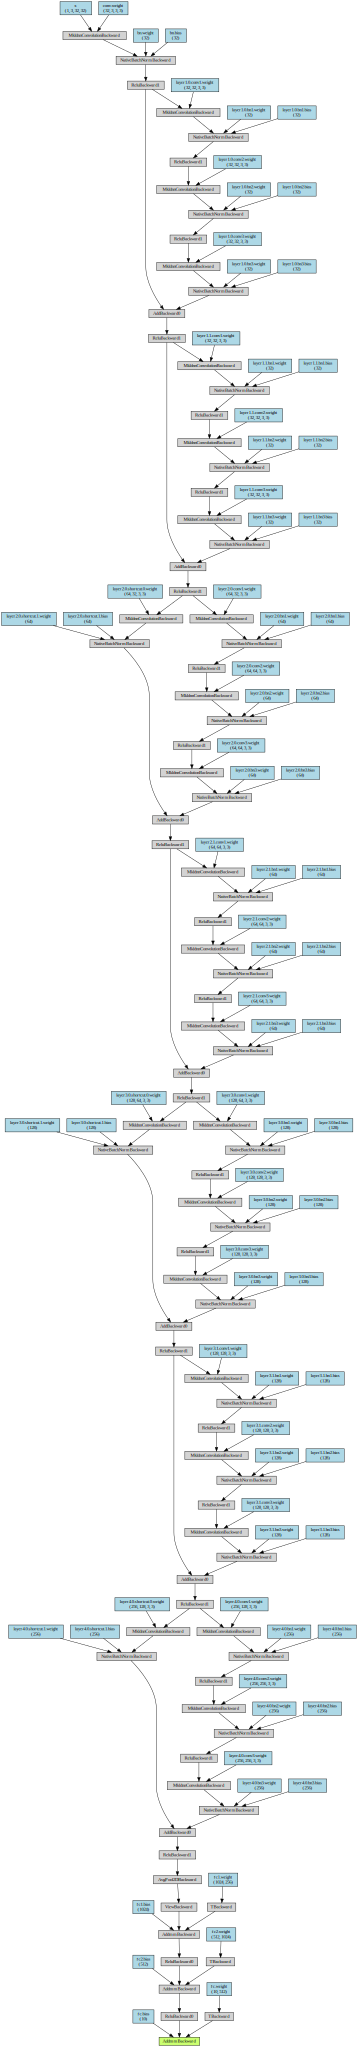

In [5]:
##################################  Model Visualisation ###################################################
model2 = FFNN()
x = torch.randn(1, 3, 32, 32).requires_grad_(True)
y = model2(x)
make_dot(y, params=dict(list(model2.named_parameters()) + [('x', x)]))

And the number of parameters of model is

In [6]:
numel_list = [p.numel() for p in model2.parameters()]
sum(numel_list)#, numel_list

3729834

#### Training

In [14]:
torch.backends.cudnn.benchmark=True      
model2 = FFNN().to(device)
model2.fit(45, 0.00052, model2, train_loader, val_loader)

Epoch [1/45], Loss: 1.5364 / 1.4985, Accuracy: 0.4213  / 0.4640 
Epoch [2/45], Loss: 1.1519 / 1.2894, Accuracy: 0.5824  / 0.5280 
Epoch [3/45], Loss: 0.9541 / 0.9810, Accuracy: 0.6598  / 0.6701 
Epoch [4/45], Loss: 0.8241 / 0.7714, Accuracy: 0.7092  / 0.7265 
Epoch [5/45], Loss: 0.7292 / 0.6925, Accuracy: 0.7453  / 0.7553 
Epoch [6/45], Loss: 0.6600 / 0.6665, Accuracy: 0.7690  / 0.7692 
Epoch [7/45], Loss: 0.6067 / 0.6398, Accuracy: 0.7875  / 0.7832 
Epoch [8/45], Loss: 0.5615 / 0.5485, Accuracy: 0.8026  / 0.8157 
Epoch [9/45], Loss: 0.5306 / 0.5421, Accuracy: 0.8156  / 0.8172 
Epoch [10/45], Loss: 0.4957 / 0.5513, Accuracy: 0.8276  / 0.8182 
Epoch [11/45], Loss: 0.4667 / 0.4736, Accuracy: 0.8378  / 0.8434 
Epoch [12/45], Loss: 0.4401 / 0.4933, Accuracy: 0.8476  / 0.8394 
Epoch [13/45], Loss: 0.4244 / 0.4873, Accuracy: 0.8517  / 0.8415 
Epoch [14/45], Loss: 0.4035 / 0.4622, Accuracy: 0.8603  / 0.8451 
Epoch [15/45], Loss: 0.3851 / 0.4748, Accuracy: 0.8672  / 0.8498 
Epoch [16/45], Loss

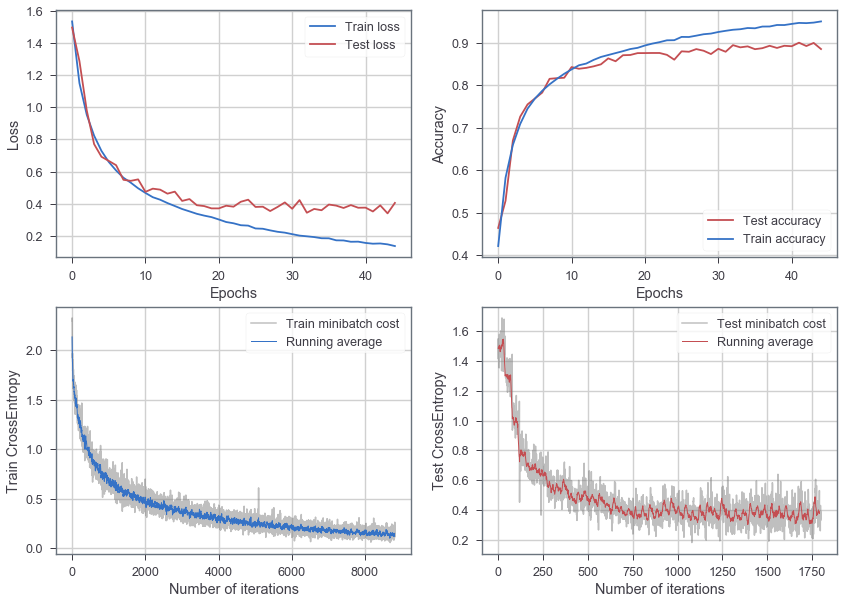

In [15]:
model2.plotti()

<All keys matched successfully>

In [16]:
model2.fit(5, 0.00052, model2, train_loader, val_loader)

Epoch [1/5], Loss: 0.1417 / 0.3813, Accuracy: 0.9491  / 0.8976 
Epoch [2/5], Loss: 0.1340 / 0.3599, Accuracy: 0.9536  / 0.9017 
Epoch [3/5], Loss: 0.1322 / 0.3908, Accuracy: 0.9531  / 0.8920 
Epoch [4/5], Loss: 0.1238 / 0.3470, Accuracy: 0.9557  / 0.9000 
Epoch [5/5], Loss: 0.1257 / 0.4114, Accuracy: 0.9550  / 0.9003 


In [17]:
torch.save(model2.state_dict(), 'res90')
########################################################
#model2.load_state_dict(torch.load('res90'))
#model2.fit(10, 0.00052, model2, train_loader, val_loader)

## The visualisation of model results

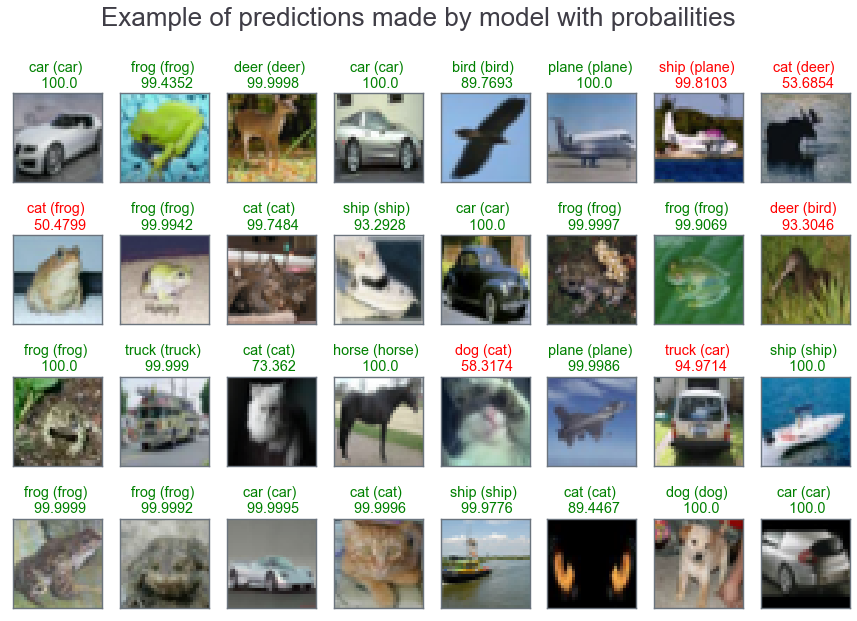

In [46]:
################ Load and denormalise images ###############################################
val_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = 32, shuffle=True)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
def im_convert(tensor):
    '''Denormalisation'''
    image = tensor.cpu().clone().detach().numpy()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)
    return image

############## Computes soft-max probability for randomnly chosen image #####################
dataiter = iter(val_loader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
output = model2(images)
_, preds = torch.max(output, 1)
output_probs = F.softmax(output, dim=1)
output_probs = output_probs.cpu()
x_pred_prob =  np.round((torch.max(output_probs.data, 1)[0]) * 100,4)

fig = plt.figure(figsize=(15, 10))
fig.suptitle('Example of predictions made by model with probailities', fontsize=26)
for idx in np.arange(32):
    sm = nn.Softmax(dim=1)
    sm_outputs = sm(output)
    ax = fig.add_subplot(4, 8, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title("{} ({}) \n {}".format(str(classes[preds[idx].item()]),\
                                     str(classes[labels[idx].item()]),\
                                     str(x_pred_prob.numpy()[idx])), \
                                     color=("green" if preds[idx]==labels[idx] else "red"))
    


These pictures are a part of results of classification in testing set. The numbers over the pictures are the probabilities, which come from softmax function, of the categories that the pictures are classified to.

#### Confusion Matrix
Here we calculate the overall accuracy of every catagory and visualise.

In [29]:
#################### Computes accuracies for each of ten categories  ######################
total_correct = 0
total_images = 0
conf_mat = np.zeros([10,10], int)
with torch.no_grad():
    for img, labels in val_loader:
        img = img.to(device)
        labels = labels.to(device)
        outputs = model2(img)
        _, predicted = torch.max(outputs.data, 1)
        total_images += labels.size(0)
        total_correct += (predicted == labels).sum().item()
        for i, k in enumerate(labels):
            conf_mat[k.item(), predicted[i].item()] += 1 

model_accuracy = total_correct / total_images * 100
##################### Produce the table #################################################
print('{0:10s} - {1}'.format('Category','Accuracy'))
for i, r in enumerate(conf_mat):
    print('{0:10s} - {1:.1f}'.format(classes[i], r[i]/np.sum(r)*100))

Category   - Accuracy
plane      - 95.2
car        - 95.3
bird       - 78.9
cat        - 78.8
deer       - 93.9
dog        - 86.9
frog       - 91.3
horse      - 91.8
ship       - 95.6
truck      - 92.6


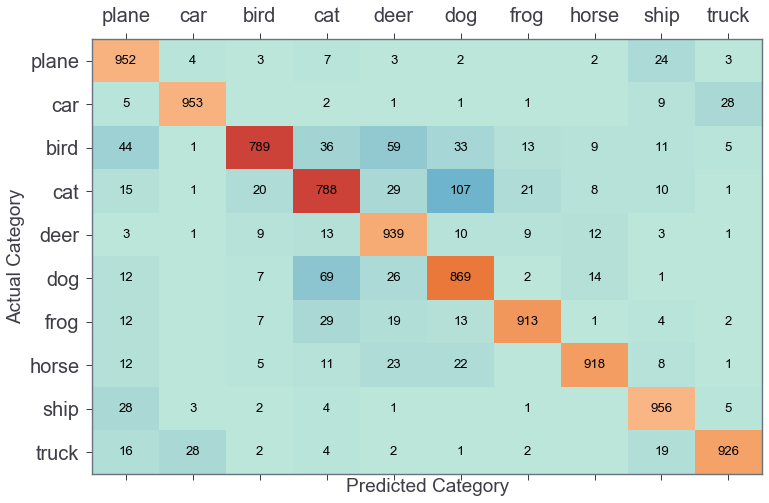

In [30]:
###################### Confusion matrix ###################################################
jtplot.style(theme="grade3", context="notebook", ticks=True, grid=False)
fig, ax = plt.subplots(1,1,figsize=(12,8))
ax.matshow(conf_mat, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('icefire'))
for i, j in zip(*conf_mat.nonzero()):
    ax.text(j, i, conf_mat[i, j], color='black', ha='center', va='center')
plt.ylabel('Actual Category', fontsize=19)
plt.yticks(range(10), classes, fontsize=20)
plt.xlabel('Predicted Category', fontsize=19)
plt.xticks(range(10), classes, fontsize=20)
plt.show()

The worst accuracy is for the cats 74.8 %. From the confusing matrix, it is evident that model classifies too many cats as dogs, i.e. false positives (I type error). On the other hand, there is unproportional number of false negatives trucks, i.e. being trucks but classified wrongly by model as not trucks (Type II error). Colloquially, the cats are like dogs, and trucks are not liked by our model in general. Note that FGSM adversarial lowers the number of true positives in favour of false negatives.

## Adversarial Attacks
To check the robustness our trained model we applied two types of adversarial attacks. The idea is that if we have input correctly classified by our model, we have to impose perturbation $\delta$ to input data $x$ in order to escape from minimum of objective function. In adversarial algorithm we set weights (trained model parameters) and compute gradients w.r.t input data. As a result, algorithm goes in direction of gradient and hence ther is a gradient ascent. Note, that in gradient descent we impose negative sign to go in opposite direction of gradient. The aim of adversarial attack is to create imperceptible data inputs such that this input is misscalsified by model.\
For perturbated input $\tilde{x}=x+\delta$ and output $y$ we obtain not true labels and we can write
\$$f_{\Theta}(\tilde{x})\neq y_{true}$$
Also, a perturbation should be fixed on each pixel by size $\epsilon$, and we obtain bounded adversarial within $\epsilon$-neigbourhood
$$||\tilde{x}-x||_{p}<\epsilon$$
The distance can be measured by means of $L_{p}$ norms.

In this notebook we decided to demonstrate the strength using proposed by Goodfellow et. all [3] Fast Gradient Sign Method (FGSM) and iterative Fast Gradient Sign Method (I-FSGM). The distance function is $L\infty$, , i.e. we measure max distance between any pixel $\tilde{x}$ and $x$.\
Basic FGSM is untargeted method that perturbs input by $\epsilon$ in one step only. "sign" becouse algorithms goes along gradient, which sign is detetected during PyTorch operations on graphs during backpropgation. Algorithm is based on following formula

$$X^{adv}=X+\epsilon\cdot sign\,(\Delta_{x}J(X, y_{true}))$$
\
The developement of FSGM is I-FGSM which imposes multiple perturbations along the gradient on graph. Naturally, this method is superior to the first because the move is more deep (it accumalutes values of gradients from $n$ iteretions of loop). We also limit the magnitude of each perturbation so that the distortion is still in $\epsilon$-neigbourhood. We took $\alpha=\frac{\epsilon}{n}$ and write
\
\
$$X_{0}^{adv} = X;\,\,\,\, X_{N+1}^{adv}=Clip_{X,\epsilon} \left \{  X_{N+1}^{adv} \,\,\alpha\cdot sign\,(\Delta_{x}J(X_{N}^{adv}, y_{true}))   \right \} \,and\,\, X_{N+1}\in [X_{N}-\epsilon, X_{N}+\epsilon]$$

In general, this algorithms shift adversarial examples beyond the set in which they are correcly put by model. In other words, true positives become false negatives. Goodfellow claims that adversarialness stems from linear beahaviours subspaces in highly unlinear spaces of neuralnetworsks [2], whereas true target is still the same. However, the newer approach claims that when dimensioanlity set of functions increases we have to deal with diffrent spaces, that is the norms of all vectors change and hence target moves [4]. 

### Implementation of FSGM and I-FSGM
We derived some ideas about the code from https://pytorch.org/tutorials/beginner/fgsm_tutorial.html

In [31]:
#################################### FGSM ATTACK ####################################################
def fgsm(model, img, target, output, eps):
    '''FGSM algorithm'''
    loss = F.nll_loss(output, target)#computes loss
    model.zero_grad() #puts gradients to 0
    loss.backward() #backpropagation
    data_grad = img.grad.data #set data to tensor
    sign_data_grad = data_grad.sign() #get sign of gradient
    perturbed_data = img + eps*sign_data_grad #as in formula
    return perturbed_data

def attack_FGSM(model, device, test_loader, epsilons):
    '''Skeleton for FGSM computations'''
    accuracies = []
    examples = []
    for eps in epsilons:
        correct = 0
        adv_examples = []
        for img, target in test2_loader:
            img, target = img.to(device), target.to(device)
            # Set requires_grad attribute of tensor. Important for Attack
            img.requires_grad = True
            # Forward pass the data through the model
            output = model2(img)
            init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            # If the initial prediction is wrong, dont bother attacking, just move on
            if init_pred.item() != target.item():
                continue
            perturbed_img = fgsm(model2, img, target, output, eps)
            output = model2(perturbed_img)
            # Check for success
            final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            if final_pred.item() == target.item():
                correct += 1
                # Special case for saving 0 epsilon examples
                if (eps == 0) and (len(adv_examples) < 2):
                    adv_ex = perturbed_img.squeeze().detach().cpu().numpy()
                    adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
            else:
                # Save some adv examples for visualization later
                if len(adv_examples) < 2:
                    adv_ex = perturbed_img.squeeze().detach().cpu().numpy()
                    adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        acc = correct/float(len(test2_loader))
        print("Epsilon: {}\tTest Accuracy = {} / {} = {:.4f}".format(eps, correct, len(test2_loader), acc))
        accuracies.append(acc)
        examples.append(adv_examples)
        
    return accuracies, examples

In [32]:
################################### I-FGSM ########################################################

def attack_iter(iters, model, device, test_loader, epsilons):
    '''Computes Iterative-FGSM'''
    accuracies2 = []
    examples2 = []
    # Run test for each epsilon
    for eps in epsilons:
        correct = 0
        adv_examples = []
        # Loop over all examples in test set
        for img, target in test_loader:
            # Send the data and label to the device
            img, target = img.to(device), target.to(device)
            # Set requires_grad attribute of tensor. Important for Attack
            img.requires_grad = True
            output = model(img)
            init_pred = output.max(1, keepdim=True)[1]
            if init_pred.item() != target.item():
                continue
            # Forward pass the data through the model
            for i in range(iters):
                output = model(img)
                loss = F.nll_loss(output, target)#compute loss
                model.zero_grad()#put all gradients in your model to zero
                loss.backward()# backpropagation
                data_grad = img.grad.data#to collect data gradients
                x_grad = eps/(i+1) * data_grad.sign()#to detetect a sign of gradient * epsilon = perturbation; like in formula
                adv_temp = img.data + x_grad # add perturbation to img which also contains perturbation from previous iterations
                total_grad = adv_temp - img #total perturbation
                #clips intermediate values after each step to ensure being in epsilon-neigbourhood
                total_grad = torch.clamp(total_grad, -eps, eps)
                x_adv = img + total_grad #add total perturbation to the original image
                img.data = x_adv
                perturbed_img = x_adv
            #perturbed_img = fsgm_iter(model2, img, target, eps, alpha)
            output = model(perturbed_img)
            # Check for success
            final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            if final_pred.item() == target.item():
                correct += 1
                # Special case for saving 0 epsilon examples
                if (eps == 0) and (len(adv_examples) < 2):
                    adv_ex = perturbed_img.squeeze().detach().cpu().numpy()
                    adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
            else:
                #for visualization later actually not neccessary here
                if len(adv_examples) < 2:
                    adv_ex = perturbed_img.squeeze().detach().cpu().numpy()
                    adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        acc = correct/float(len(test2_loader))
        print("Epsilon: {}\tTest Accuracy = {} / {} = {:.4f}".format(eps, correct, len(test_loader), acc))
        # Return the accuracy and an adversarial example
        accuracies2.append(acc)
        examples2.append(adv_examples)
    return accuracies2, examples2

#### Computations
In Goodfellow paper [3] author used $\alpha$ = 1, which means that the value of pixel change shifts by 1 during each iteration only. However, in our case we apply $\alpha=\frac{\epsilon}{n}$. This approach allows to adjust the number of iterations to the the need of staying in $\epsilon$-neigbourhood. Further, for comparison, we performed iterative attack with 2, 3 and 5 iterations, successively.  

In [33]:
##################### Load data and parameters ######################################################
model2.load_state_dict(torch.load('res90'))
test2_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = 1, shuffle=False)
model2.eval().to(device)
epsilons = [0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.08, 0.1, 0.12]

In [34]:
#retrain the model agin and perform attacks, it  works!!!
acc_fgsm, ex_fgsm = attack_FGSM(model2, device, test2_loader, epsilons)

Epsilon: 0	Test Accuracy = 9003 / 10000 = 0.9003
Epsilon: 0.01	Test Accuracy = 7670 / 10000 = 0.7670
Epsilon: 0.02	Test Accuracy = 6179 / 10000 = 0.6179
Epsilon: 0.03	Test Accuracy = 4846 / 10000 = 0.4846
Epsilon: 0.04	Test Accuracy = 3834 / 10000 = 0.3834
Epsilon: 0.05	Test Accuracy = 3030 / 10000 = 0.3030
Epsilon: 0.06	Test Accuracy = 2436 / 10000 = 0.2436
Epsilon: 0.08	Test Accuracy = 1624 / 10000 = 0.1624
Epsilon: 0.1	Test Accuracy = 1142 / 10000 = 0.1142
Epsilon: 0.12	Test Accuracy = 825 / 10000 = 0.0825


In [35]:
acc_Iter_2, ex_Iter_2 = attack_iter(2, model2, device, test2_loader, epsilons)

Epsilon: 0	Test Accuracy = 9003 / 10000 = 0.9003
Epsilon: 0.01	Test Accuracy = 6811 / 10000 = 0.6811
Epsilon: 0.02	Test Accuracy = 4483 / 10000 = 0.4483
Epsilon: 0.03	Test Accuracy = 2762 / 10000 = 0.2762
Epsilon: 0.04	Test Accuracy = 1642 / 10000 = 0.1642
Epsilon: 0.05	Test Accuracy = 941 / 10000 = 0.0941
Epsilon: 0.06	Test Accuracy = 516 / 10000 = 0.0516
Epsilon: 0.08	Test Accuracy = 199 / 10000 = 0.0199
Epsilon: 0.1	Test Accuracy = 70 / 10000 = 0.0070
Epsilon: 0.12	Test Accuracy = 31 / 10000 = 0.0031


In [36]:
acc_Iter_3, ex_Iter_3 = attack_iter(3, model2, device, test2_loader, epsilons)

Epsilon: 0	Test Accuracy = 9003 / 10000 = 0.9003
Epsilon: 0.01	Test Accuracy = 6212 / 10000 = 0.6212
Epsilon: 0.02	Test Accuracy = 3460 / 10000 = 0.3460
Epsilon: 0.03	Test Accuracy = 1725 / 10000 = 0.1725
Epsilon: 0.04	Test Accuracy = 772 / 10000 = 0.0772
Epsilon: 0.05	Test Accuracy = 347 / 10000 = 0.0347
Epsilon: 0.06	Test Accuracy = 156 / 10000 = 0.0156
Epsilon: 0.08	Test Accuracy = 29 / 10000 = 0.0029
Epsilon: 0.1	Test Accuracy = 11 / 10000 = 0.0011
Epsilon: 0.12	Test Accuracy = 1 / 10000 = 0.0001


In [37]:
acc_Iter_5, ex_Iter_fgsm_5 = attack_iter(5, model2, device, test2_loader, epsilons)

Epsilon: 0	Test Accuracy = 9003 / 10000 = 0.9003
Epsilon: 0.01	Test Accuracy = 5364 / 10000 = 0.5364
Epsilon: 0.02	Test Accuracy = 2340 / 10000 = 0.2340
Epsilon: 0.03	Test Accuracy = 792 / 10000 = 0.0792
Epsilon: 0.04	Test Accuracy = 255 / 10000 = 0.0255
Epsilon: 0.05	Test Accuracy = 80 / 10000 = 0.0080
Epsilon: 0.06	Test Accuracy = 20 / 10000 = 0.0020
Epsilon: 0.08	Test Accuracy = 2 / 10000 = 0.0002
Epsilon: 0.1	Test Accuracy = 0 / 10000 = 0.0000
Epsilon: 0.12	Test Accuracy = 0 / 10000 = 0.0000


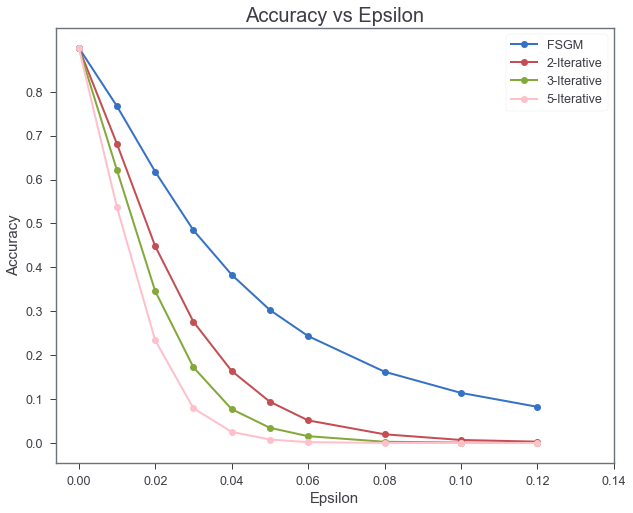

In [38]:
#to plot retrain the model agin and perform attacks, it should work!!!
#jtplot.style(theme="grade3", context="notebook", ticks=True, grid=True)
plt.figure(figsize=(10,8))
plt.plot(epsilons, acc_fgsm, c='b', marker='o', label='FSGM', linewidth=2.0)
plt.plot(epsilons, acc_Iter_2, c='r', marker='o', label='2-Iterative', linewidth=2.0)
plt.plot(epsilons, acc_Iter_3, c='g', marker='o', label='3-Iterative', linewidth=2.0)
plt.plot(epsilons, acc_Iter_5, c='pink', marker='o', label='5-Iterative', linewidth=2.0)
plt.yticks(np.arange(0, 0.9, step=0.1))
plt.xticks(np.arange(0, .14, step=0.02))#change axis as you wish
plt.title("Accuracy vs Epsilon",fontsize=20)
plt.xlabel("Epsilon",fontsize=15)
plt.ylabel("Accuracy",fontsize=15)
plt.legend()
plt.show()


From the above results, we observe that any iterative method is superior to one-step FSGM.  Iterative FGSM are more efficient because the magnitude of accumulated gradients are larger and allow quicker to escape perturbed input from the set of true positives to false negatives, i.e. to any other set but not correct one. There is also option to try the Iterative Least-Likely Method in which we can specify the targeted class; however, there are only ten classes in CIFAR10, and we conclude it would not be a significant refinement in our case. Another idea would be to attack through Projected Gradient Descent (PGD). In this algorithm, after each perturbation PDG projects the adversarial input onto a $\epsilon$-ball of $X$ if necessary. Therefore, the direction of the gradient of escape is set more optimally.

To defence our model against adversarial attack, we could apply so-called adversarial training, that is some GAN in the training loop. In this case, a model is trained according to the Nash mini-max equilibrium. Another idea, for defence, would be applying threshold filters in convolutional layers $ReLU(ax-\delta)$, in which activation is unchanged for any "irrelevant" perturbation smaller than $\delta$ [6].

#### FGSM Attack visualisation

In [39]:
#################################### functions ###################################################
def fgsm_attack(img, eps, data_grad):
    '''Attack for particular image'''
    sign_data_grad = data_grad.sign()
    perturbed_img = img + eps*sign_data_grad
    return perturbed_img

def fgsm_test(model, device, test_loader, epsilon ):
    '''Computes softmax probailities for visualisations'''
    correct = 0
    adv_examples = []
    x_prob = []

    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        data.requires_grad = True
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if init_pred.item() != target.item():
            continue

        loss = F.nll_loss(output, target)
        model.zero_grad()
        loss.backward()
        data_grad = data.grad.data
        #Apply attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)
        output = model(perturbed_data)
        output_probs = F.softmax(output, dim=1)#standardise for probability
        output_probs = output_probs.cpu()
        #get probability for given image from tensor
        x_pred_prob =  (np.round((torch.max(output_probs.data, 1)[0]) * 100,4)).numpy()
        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1

        if len(adv_examples) < 7:
            adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
            adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
            x_prob.append(x_pred_prob)
    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {:.4f} / {} = {:.4f}".format(epsilon, correct, len(test_loader), final_acc))
    # Return the accuracy and an adversarial example
    return final_acc, adv_examples, x_prob

In [40]:
###################################### Experiment ##############################################
model2.eval()
#use_cuda=True
epsilons = [0, 0.01, 0.02, 0.03, 0.04, 0.1, 0.15, 0.5]
accuracies = []
examples = []
probas = []
# Run test for each epsilon
for eps in epsilons:
    acc, ex, proba = fgsm_test(model2, device, test2_loader, eps)
    accuracies.append(acc)
    examples.append(ex)
    probas.append(proba)

Epsilon: 0	Test Accuracy = 9003.0000 / 10000 = 0.9003
Epsilon: 0.01	Test Accuracy = 7670.0000 / 10000 = 0.7670
Epsilon: 0.02	Test Accuracy = 6179.0000 / 10000 = 0.6179
Epsilon: 0.03	Test Accuracy = 4846.0000 / 10000 = 0.4846
Epsilon: 0.04	Test Accuracy = 3834.0000 / 10000 = 0.3834
Epsilon: 0.1	Test Accuracy = 1142.0000 / 10000 = 0.1142
Epsilon: 0.15	Test Accuracy = 636.0000 / 10000 = 0.0636
Epsilon: 0.5	Test Accuracy = 709.0000 / 10000 = 0.0709


#### Prediction of probabilities and visualisations for each class after FGSM attack

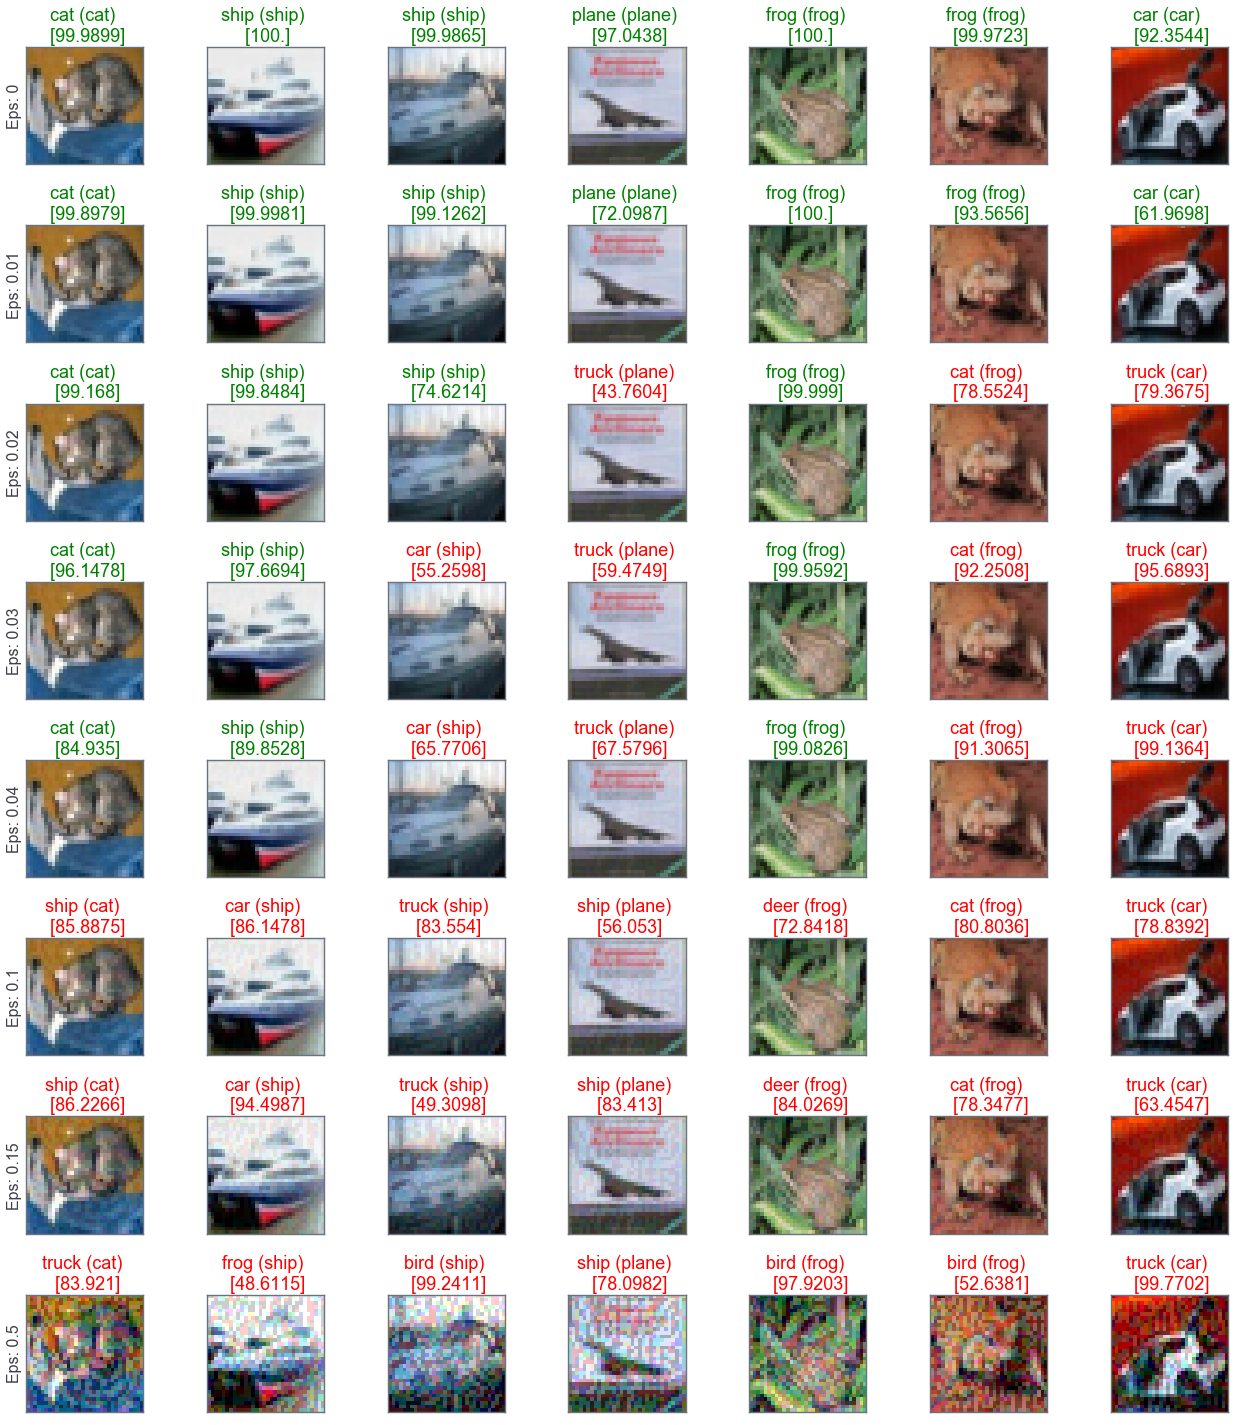

In [41]:
###################################### Visualisations ###########################################
#jtplot.style(theme="grade3", context="notebook", ticks=True, grid=True)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def im_convert_2(tensor):
    '''Denormalisation'''
    image = tensor.transpose(1, 2, 0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)
    return image

cnt = 0
plt.figure(figsize=(18,20))
#plt.suptitle('Examples of predictions of model with probailities after FGSM attack', fontsize=28)
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=16)
        orig,adv,ex = examples[i][j]
        plt.title("{} ({}) \n {}".format(str(classes[adv]),\
                                    str(classes[orig]),\
                                    str(probas[i][j]) ), \
                                    color=("green" if classes[orig]==classes[adv] else "red"), fontsize=18)
        plt.imshow(im_convert_2(ex[:,:]))
plt.tight_layout()
plt.show()
#plt.savefig('FSGM_attack.png')

On the picture above, we can see the work of the FGSM attack. Small perturbation disturbs the process of classification, and our model mispredicts classes. 

## Summary

In our work, we built and trained neural network model to classify CIFAR10 images. We based the structure of NN on residual architecture with "skipping connections" that mitigates the problem of vanishing gradients. Note, that by-passing is typical for neural structures of living organisms. 
We achieved 90 % accuracy in 50 epochs. To obtain a better result, it would be advisable to build more intricate NN capturing more subtle features of classified images and hyperparameters tuning.\
Performed adversarial attacks demonstrated how successfully to decrease the performance of our model. The results show the iterative methods outstrips a single-step approach. For future work, it is necessary to understand the mathematics of both universal approximation and the ways perturbing (AKA foxing) trained neural networks. As a result, we will be able to create more robust neural networks, attacking algorithms and defence. 

## References

[1]  He, K., Zhang, X., Ren, S. and Sun, J., 2016. Deep residual learning for image recognition. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 770-778).\
[2] Goodfellow, I.J., Shlens, J. and Szegedy, C., 2014. Explaining and harnessing adversarial examples. arXiv preprint arXiv:1412.6572.\
[3] Kurakin, A., Goodfellow, I. and Bengio, S., 2016. Adversarial examples in the physical world. arXiv preprint arXiv:1607.02533.\
[4] Dube, S., 2018. High dimensional spaces, deep learning and adversarial examples. arXiv preprint arXiv:1801.00634.\
[5] Zagoruyko, S. and Komodakis, N., 2016. Wide residual networks. arXiv preprint arXiv:1605.07146.\
[6] Tsipras, D., Santurkar, S., Engstrom, L., Turner, A. and Madry, A., 2018. Robustness may be at odds with accuracy. arXiv preprint arXiv:1805.12152.